<a href="https://colab.research.google.com/github/wdconinc/practical-computing-for-scientists/blob/master/Lectures/lecture23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture #23

In [0]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
import scipy.integrate as ig

##Signal processing and analysis

###Motivation

__Signals__ 

For our purposes, a _signal_ is a sequence of $N$ measurements ("samplings") of some quantity $f$, usually at different times $t$: 

$$\{f_n\} = \{f_0,f_1,\dots,f_{N-1}\}$$

__Examples__

* Digital oscilloscope trace:
  * The output of some antenna or detector
  * The voltage at some point in a circult
* More generically, the output of any Analog to Digital Convertor
* Stock market data
* Weather data
* images: pixel color at different $x,y$ (a 2D example)

__Continuum limit__

We presume that if we look at finer and finer samples ($N\to \infty$) the signal becomes a better and better estimate of some continuous function $f(t)$. We can therefore hope to translate some of the mathematics developed for continuous functions (in particular Fourier transforms) to work with signals.

__Signal processing__

A model for signal processing is shown below:

\begin{array}{ccc}
\mbox{input signal} & \mbox{process} & \mbox{ output signal} \\
\{f_n\} \longrightarrow &  H & \longrightarrow  \{f'_n\} 
\end{array}

The process $H$ is anything that modifies an input signal to yield an output signal. This could be an algorithm, if we think of $\{f_n\}$ as numbers in a computer's memory, or a physical system, if we think of them as actual waveforms that we have sampled before and/or after the action of the system.

__ Three general situations __

* If we know $\{f_n\}$ and $\{f'_n\}$ we can learn about $H$. For example we might imagine $\{f_n\}$ is an outgoing radar pulse and $\{f'_n\}$ is the return pulse. By analyzing the two we learn about the system of planes in the air - $H$.

* If we know $H$ and $\{f'_n\}$ we can learn about $\{f_n\}$. For example, $\{f'_n\}$ could be the output of our detector, measured on an oscilloscope. $H$ is the way our detector responds to incoming signals - practical detectors have resistance and capacitance and therefore cannot respond infinitely quickly. We want to go from $\{f'_n\}$ to $\{f_n\}$, the "true" signal. This procedure is called "deconvolution" or "unfolding".

* If we know $\{f_n\}$ and $H$ we can make a new one $\{f'_n\}$ with some improved quality. This is called "filtering". Noise removal and image enhancement algorithms do this. Data compression algorithms do something like this.

__ Convolution and Correlation __

Consider the case in which we have two signals $f(t)$ and $g(t)$. The _convolution_ of the two is:

$$ f*g = \int_{-\infty}^{+\infty} g(\tau)f(t-\tau) d\tau $$

Here's an example, in which the function $g(t)$ is a normal distribution (potentially a good model for detector resolution/smearing) and $f(t)$ has narrow spikes. The resulting convolution spreads out the spikes, leaving their location intact (since $f,g$ are symmetric).  

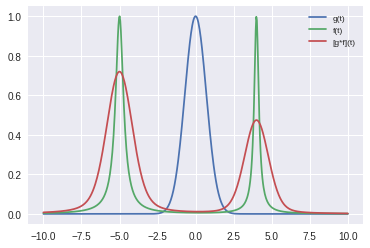

In [0]:
def g(x):
    return np.exp(-x**2)

def f(x):
    return 1 / ((30*(x-4)**2 + 1)) + 1 / ((10*(x+5)**2 + 1))

def conv(f,g,t,a,b):
    fg = lambda tau,t: g(tau) * f(t-tau)
    return ig.quad(fg, a, b, args = (t))[0]

T = np.linspace(-10,10,500)
conv_result = np.zeros_like(T)
for i,t in enumerate(T):
    conv_result[i] = conv(f, g, t, -10, 10)

plt.plot(T, g(T), T, f(T), T, conv_result)
plt.legend(('g(t)', 'f(t)', '[g*f](t)'), fontsize = 'small', loc = 'upper right') 

The _correlation_ of two signals is similar:

$$ C(t) = \int_{-\infty}^{+\infty} g(\tau+t)f(\tau) d\tau $$

In [0]:
def corr(f, g, t, a, b):
    fg = lambda tau, t: g(tau+t)*f(tau)
    return ig.quad(fg, a, b, args = (t))[0]

T = np.linspace(-10,10,500)
corr_result = np.zeros_like(T)
for i,t in enumerate(T):
    corr_result[i] = corr(f, g, t, -10, 10)

plt.plot(T, g(T), T, f(T), T, corr_result)
plt.legend(('g(t)', 'f(t)', 'C(t)'), fontsize = 'small', loc = 'upper right')

###Fourier Transforms

__Fourier's Theorem__

_Every reasonably continuous function $f(t)$ can be expressed as a sum, perhaps infinite, of sine and cosine functions with different frequencies $\omega=2\pi f$._  Closely related is the _Fourier transform_

$$f(t) = \int_{-\infty}^{+\infty} F(\omega) e^{i\omega t} \frac{\mathrm{d}\omega}{2\pi}$$

$F(\omega)$ is the "frequency domain" representation of the "time domain" function f(t).  There is an inverse transform:

$$F(\omega)=\int_{-\infty}^{+\infty} f(t) e^{-i\omega t} \mathrm{d}t$$

$f(t)$ and $F(\omega)$ are equally valid ways of looking at the function. It will turn out that understanding and manipulating signals is often best done in the frequency domain. Examples:

* Perhaps my detector is an antenna and the nearby interaction of a hypothesized new particle would create an electro-magnetic wave with a particular frequency (or tone). This might not stand out in the time domain, but would show up as a peak in the frequency domain (if "loud" enough).

* Perhaps I have some 60Hz noise messing with my experiment. I could transform to the frequency domain, mask out the region around 60Hz, then translate back to the time domain.


0n a computer we can calculate a discretized version of the Fourier transform (DFT) which is not only useful for converting to and from the frequency domain, but can also be used to implement correlations and covariances.  In particular, a clever, efficient version of the DFT, called the Fast Fourier Transform (FFT) makes many problems especially tractable with Fourier methods. 

Note: The relation between $t$ and $w$ is a bit like the relation between $x$ and $p$ in quantum mechanics. They are _conjugate variables_, related by the Fourier transform. 

###Example: exponential decay

Consider an exponential decay:

$$f(t)=e^{-at} \quad 0<t<\infty \quad \mbox{and zero elsewhere}.$$ 

The Fourier transform is:

\begin{align}
F(\omega) &= \int_{0}^{+\infty} e^{-at} e^{-i\omega t}\mathrm{d}t \\
 &= \frac{-1}{a+i\omega} e^{-(a+\omega t)} \Big|^\infty_0 \\
 &= \frac{1}{a+i\omega}
 \end{align}
 
Note, the frequency domain is complex, even though the time domain is real. That is generally true. We can describe the complex number in terms of a real and imaginary part:

$$ F(\omega) = \frac{a-i\omega}{a^2+\omega^2}$$

or in terms of a magnitude and phase ($\phi$):

$$ F(\omega)=|F(\omega)| e^{i\phi} $$

with 

$$|F(\omega)|=\frac{1}{\sqrt{a^2+\omega^2}}$$ 

and 

$$\phi=\arctan\frac{\Im\{F(\omega)\}}{\Re\{F(\omega)\}}=\arctan\frac{\omega}{a}$$

We plot $f(t)$ and $F(\omega)$ below.

In [0]:
fexp = lambda t,a: np.exp(-a*t)
Fexp = lambda w,a: 1 / (a + 1J*w)
a = 2
t = np.linspace(0,4)
plt.plot(t, fexp(t,a))

In [0]:
w = np.linspace(-20/a, 20/a)
plt.plot(w, np.absolute(Fexp(w, a)))

In [0]:
plt.plot(w, np.angle(Fexp(w, a)))